In [2]:
# Prelude
import ralphlib
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

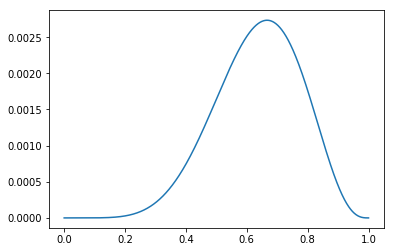

In [3]:
# 3E1
def world_toss_likelihood(num_water, num_tries):
    return lambda grid: stats.binom.pmf(num_water, num_tries, grid)

grid = np.linspace(start=0, stop=1, num=1000)
posterior = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        world_toss_likelihood(6, 9),
        grid
    ),
    index=grid
)
posterior.plot()

In [4]:
posterior[posterior.index >= 0.2].sum()

0.9991439048705782

(array([   53.,   522.,  2557.,  7065., 13974., 21279., 24077., 19479.,
         9518.,  1476.]),
 array([0.09409409, 0.18308308, 0.27207207, 0.36106106, 0.45005005,
        0.53903904, 0.62802803, 0.71701702, 0.80600601, 0.89499499,
        0.98398398]),
 <a list of 10 Patch objects>)

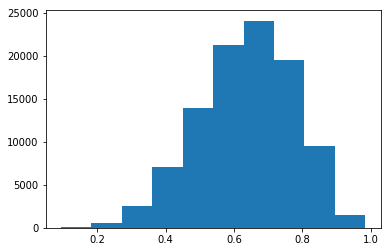

In [5]:
sample_size = 100000
sample = ralphlib.sample(posterior, sample_size)
plt.hist(sample)

In [6]:
param_values, counts = np.unique(sample, return_counts=True)
sample_freq = pd.Series(
    index=param_values,
    data=counts / sample_size
)

In [7]:
# 3E1
# Note: we are working with frequencies here! 
sample_freq[sample_freq.index < 0.2].sum()

0.0009000000000000001

In [8]:
# 3E2
sample_freq[sample_freq.index > 0.8].sum()

0.12037

In [9]:
# 3E3
sample_freq[(sample_freq.index > 0.2) & (sample_freq.index < 0.8)].sum()

0.87873

In [10]:
# 2E4
# Note: we are working directly with samples here!
# It's not easy (or possible? I think you need actual occurrence numbers and 
# not just frequency/probability?) to compute quantiles over frequencies/
# probabilities.
quantile0_2 = np.quantile(sample, 0.2)
quantile0_2

0.5175175175175175

In [11]:
sample_freq[sample_freq.index <= quantile0_2].sum()

0.20148999999999997

In [12]:
# 2E5
quantile0_8 = np.quantile(sample, 0.8)
quantile0_8

0.7607607607607607

In [13]:
sample_freq[sample_freq.index > quantile0_8].sum()

0.19879

In [14]:
# 3E6
def hdpi(sample, density):
    """Compute the highest density interval of the given density
    using the given samples from a distribution."""
    param_values, counts = np.unique(sample, return_counts=True)
    distribution = pd.Series(
        index=param_values,
        data=counts / len(sample)
    )
    
    distr_cumsum = distribution.cumsum()
    cumsum_density = distr_cumsum + density
    cumsum_density = cumsum_density[cumsum_density <= 1.0]
    # TODO do we need to finagle the np.quantile call to ensure it
    # only returns parameter values in the grid?
    q_series = cumsum_density.apply(lambda q: np.quantile(sample, q))
    
    fin_series = pd.Series(
        data=(q_series.values - q_series.index),
        index=q_series
    )
    
    fin_df = pd.DataFrame(
        data={
            "rhs": q_series.values,
            "width": q_series.values - q_series.index
        },
        index=q_series.index
    )
    
    # interval of given density with minimum width
    lhs = fin_df["width"].idxmin()
    return (lhs, fin_df["rhs"][lhs])

In [15]:
hpdi_interval = hdpi(sample, 0.66)

In [16]:
# 3E7
outside_half_density = (1-0.66)/2
eq_lhs = np.quantile(sample, outside_half_density)
eq_rhs = np.quantile(sample, 1 - outside_half_density)
symmetric_interval = (eq_lhs, eq_rhs)

In [17]:
# bonus: what is the value of p with maximal density?
sample_freq.idxmax()

0.6266266266266266

In [18]:
# bonus: widths of the two intervals
symmetric_width = symmetric_interval[1] - symmetric_interval[0]
hpdi_width = hpdi_interval[1] - hpdi_interval[0]
(symmetric_width, hpdi_width)

(0.27527527527527523, 0.27227227227227224)

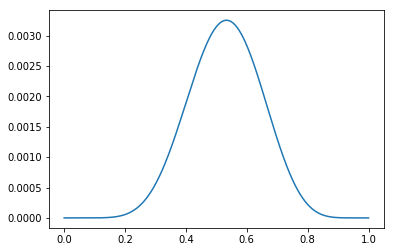

In [19]:
# 3M1
posterior2 = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        world_toss_likelihood(8, 15),
        grid
    ),
    index=grid
)
posterior2.plot()

In [20]:
# 3M2
sample2 = ralphlib.sample(posterior2, 10000)
hdpi(sample2, 0.9)

(0.3303303303303303, 0.7167167167167167)

(array([   4.,   28.,  117.,  258.,  544.,  821., 1141., 1340., 1492.,
        1369., 1193.,  860.,  495.,  236.,  102.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

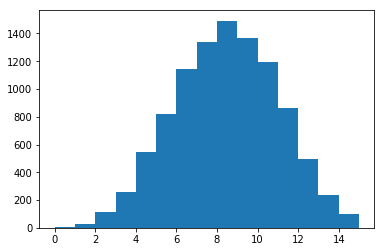

In [21]:
# 3M3
posterior_predictive_samples = np.vectorize(lambda p: np.random.binomial(15, p))(sample2)
plt.hist(posterior_predictive_samples, range(0, 16))

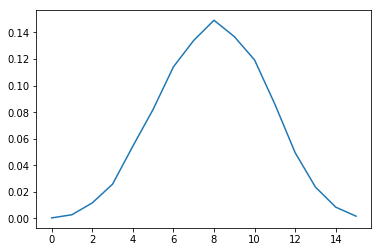

In [22]:
pp_vals, pp_counts = np.unique(posterior_predictive_samples, return_counts=True)
pp_distr = pd.Series(
    data=pp_counts / len(posterior_predictive_samples),
    index=pp_vals
)
pp_distr.plot()

In [33]:
pp_distr[8]

0.157484

In [24]:
# 3M4
posterior_predictive_samples_3m4 = np.vectorize(lambda p: np.random.binomial(9, p))(sample2)
pp_3m4_vals, pp_3m4_counts = np.unique(posterior_predictive_samples_3m4, return_counts=True)
pp_3m4_distr = pd.Series(
    data=(pp_3m4_counts / len(sample2)),
    index=pp_3m4_vals
)
pp_3m4_distr[6]

0.1795

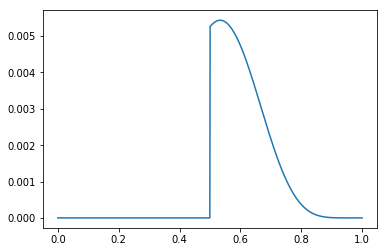

In [25]:
# 3M7
def nonuniform_prior(grid):
    gte0_5_prior = ralphlib.uniform_prior(grid[grid >= 0.5])
    gte0_5_prior *= 2
    lt0_5_prior = grid[grid < 0.5]
    lt0_5_prior.fill(0)
    return pd.Series(
        data=np.concatenate((lt0_5_prior, gte0_5_prior)),
        index=grid
    )

posterior_non_uniform = pd.Series(
    data=ralphlib.grid_approx(
        nonuniform_prior,
        world_toss_likelihood(8, 15),
        grid
    ),
    index=grid
)
posterior_non_uniform.plot()

(array([2.47820e+05, 2.34797e+05, 2.03266e+05, 1.46556e+05, 9.26350e+04,
        4.96230e+04, 1.91300e+04, 5.30200e+03, 8.13000e+02, 5.80000e+01]),
 array([0.5005005 , 0.54594595, 0.59139139, 0.63683684, 0.68228228,
        0.72772773, 0.77317317, 0.81861862, 0.86406406, 0.90950951,
        0.95495495]),
 <a list of 10 Patch objects>)

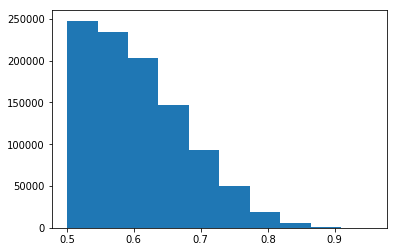

In [26]:
nonuniform_sample = ralphlib.sample(posterior_non_uniform, 1000000)
plt.hist(nonuniform_sample)

In [27]:
hdpi(nonuniform_sample, 0.9)

(0.5005005005005005, 0.7157157157157157)

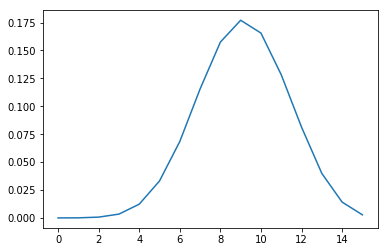

In [28]:
pp_sample = np.vectorize(lambda p: np.random.binomial(15, p))(nonuniform_sample)
pp_vals, pp_counts = np.unique(pp_sample, return_counts=True)
pp_distr = pd.Series(
    data=pp_counts / len(pp_sample),
    index = pp_vals
)
pp_distr.plot()

In [29]:
pp_distr[8]

0.157484

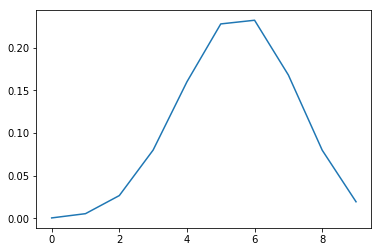

In [30]:
pp_sample9 = np.vectorize(lambda p: np.random.binomial(9, p))(nonuniform_sample)
pp_vals9, pp_counts9 = np.unique(pp_sample9, return_counts=True)
pp_distr9 = pd.Series(
    data=pp_counts9 / len(pp_sample9),
    index = pp_vals9
)
pp_distr9.plot()

In [37]:
pp_distr9[1]

0.005485

The prior shifted probability density in the posterior predictive check to the right -- to more water. In the posterior distribution over $p$ itself, the entire region below 0.5 is zeroed out. 

In [39]:
# Hard problem intro
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

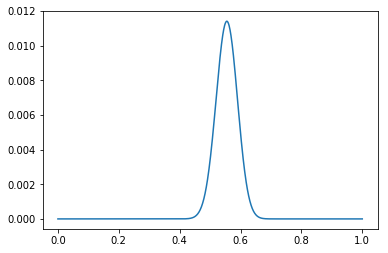

In [43]:
# 3H1
def births_likelihood(births):
    return lambda grid: stats.binom.pmf(sum(births), len(births), grid)

births_grid = np.linspace(start=0, stop=1, num=1000)
births_posterior = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        births_likelihood(np.concatenate((birth1, birth2))),
        births_grid
    ),
    index=births_grid
)
births_posterior.plot()

In [48]:
# maximum a posteriori estimate of p == probability of boy
births_map = births_posterior.idxmax()
births_map

0.5545545545545546

In [54]:
# 3H2
births_sample = ralphlib.sample(births_posterior, 10000)
[
    hdpi(births_sample, 0.5),
    hdpi(births_sample, 0.89),
    hdpi(births_sample, 0.97)
]

[(0.5315315315315315, 0.5785785785785785),
 (0.5005005005005005, 0.6126126126126126),
 (0.4754754754754755, 0.6256256256256256)]

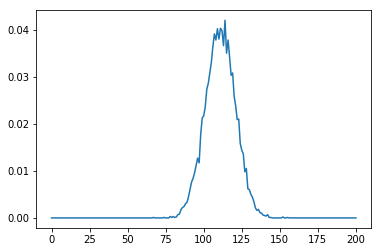

In [63]:
gen_births_pp_sample = np.vectorize(lambda p: np.random.binomial(len(birth1) + len(birth2), p))
births_pp_sample = gen_births_pp_sample(births_sample)
births_pp_freq = ralphlib.normalize(births_pp_sample, range(0, len(birth1) + len(birth2) + 1))
births_pp_freq.plot()

In [74]:
(sum(birth1) + sum(bhdpi(births_pp_sample, 0.3)

(104, 112.0)

In [ ]:
births_pp_freq[sum(birth)]